# DATA

In [1]:
%load_ext autoreload
%autoreload 2
import genericIO
import SepVector
import Hypercube
import numpy as np
import Operator
import time

In [2]:

n1 = 200
n2 = 200 

d1 = 20
d2 = 10

o1 = 0
o2 = 0

slow = SepVector.getSepVector(Hypercube.hypercube(ns=[n1,n2],ds=[d1,d2],os=[o1,o2]),storage='dataComplex')

slowNd = slow.getNdArray()
slowNd[:].real = 1/2000
slowNd[int(1.5*n2/3)::,:].real = 1/3000

In [62]:
import WEM 
import json

ns = 5
par = {
    "ns" : ns,
    "dsx" : (n1-1)*d1/(ns-1),
    "osx" : 0,
    "dsz" : 0,
    "osz" : 50,
    
    "nr" : n1,
    "drx" : d1,
    "orx" : 0,
    "drz" : 0,
    "orz" : 0,
    
    "fmin" : 1, 
    "fmax" : 15,  
    
    "nref" : 1,
    "tap" : 200,
    "ng" : 3,
    "prop" : 'ssf',
    
    "ntaylor" : 1,
    "onepass" : 0
    
}


ot = 0
tmax = 3
dt = 0.004
nt = int((tmax-ot) / dt)
wave = SepVector.getSepVector(Hypercube.hypercube(ns=[nt],ds=[dt],os=[ot]))
waveNd = wave.getNdArray()
t = np.linspace(ot,tmax,nt) - .5
f0 = 5
waveNd[:] = (1-2*(np.pi*f0*t)**2)* np.exp(-(np.pi*f0*t)**2)
print(waveNd.shape)
# waveNd = np.roll(waveNd,-int(0.5/dt))

data = SepVector.getSepVector(Hypercube.hypercube(ns=[nt,par["nr"],par["nr"]],ds=[dt,par["drx"],par["dsx"]],os=[ot,par["orx"],par["osx"]]))
datNd = data.getNdArray()

parObj = genericIO.pythonParams(par).getCpp()

(750,)


/opt/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


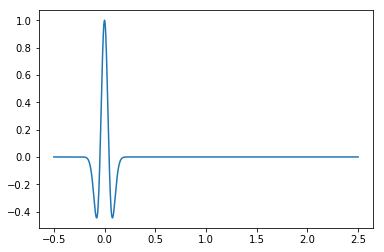

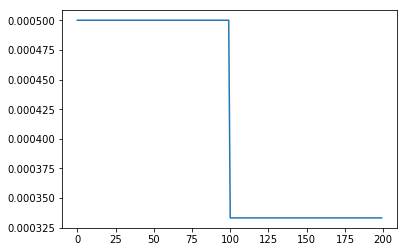

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t,waveNd)

plt.figure()
plt.plot(slowNd[:,0])

In [66]:
import WEM
wem = WEM.WEM(slow,data,wave,parObj)

wem.forward(False,slow,data)


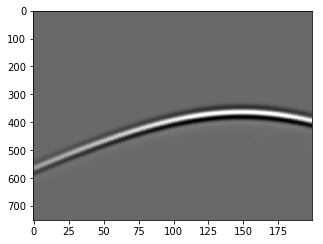

In [67]:
plt.figure(figsize=[5,10])
pclip = .9
which = 3
a_max = pclip*np.amax(datNd[which,:,:])
a_min = pclip*np.amin(datNd[which,:,:])
plt.imshow(np.clip(datNd[which,:,:].T,a_max=a_max, a_min=a_min),cmap='gray',aspect=.2)
plt.show()

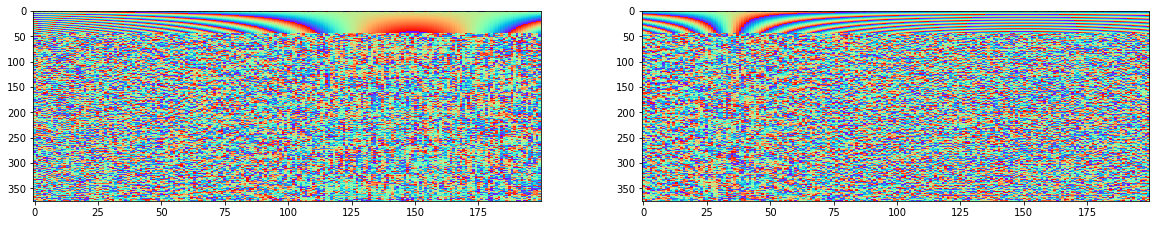

In [103]:

S = np.fft.fft(datNd[which,:,:].T,axis=0)
ph = np.angle(S)
t0 = -.5
w = 2*np.pi*np.linspace(0,1/dt,t.size)
SS = S.T*np.exp(-1j*w*t0)
phh = np.angle(SS).T
# phh[int(t.size/2):] = np.flip(phh[:int(t.size/2)],0)
fig, ax = plt.subplots(1,2,figsize=[20,20])
ax[0].imshow(ph[:int(t.size/2),:],aspect=.2,cmap='rainbow')
ax[1].imshow(phh[:int(t.size/2),:],aspect=.2,cmap='rainbow')

plt.show()

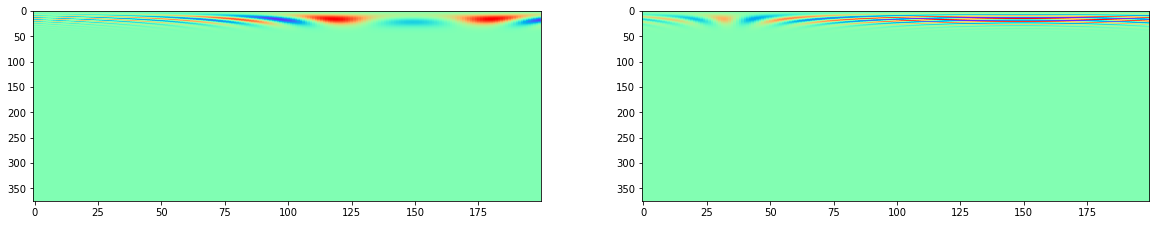

In [104]:

fig, ax = plt.subplots(1,2,figsize=[20,20])
ax[0].imshow(S.real[:int(t.size/2),:],aspect=.2,cmap='rainbow')
ax[1].imshow(SS.T.real[:int(t.size/2),:],aspect=.2,cmap='rainbow')

plt.show()

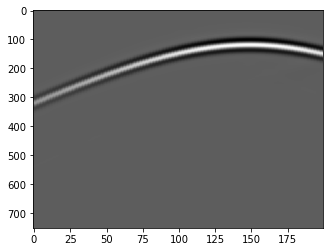

In [95]:

s = np.fft.ifft(SS.T,axis=0).real
plt.imshow(s,cmap='gray',aspect=.2)
plt.show()

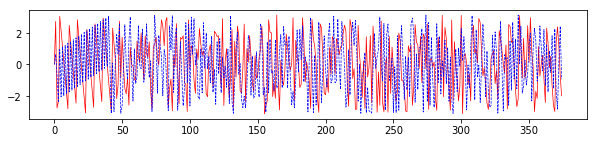

In [96]:
plt.figure(figsize=[10,2])
plt.plot(phh[:int(t.size/2),150],'red',linewidth=.7)
plt.plot(ph[:int(t.size/2),150],'blue',linestyle='--',linewidth=.7)

In [6]:
image = slow.clone()
born = WEM.Born(slow,data,wave,parObj)

In [70]:
born.adjoint(False,image,data)

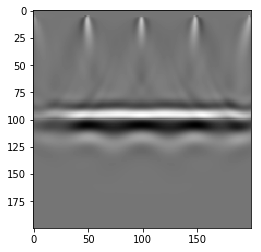

In [73]:
plt.imshow(image.getNdArray().real,cmap='gray')
plt.show()

# Wrong bg

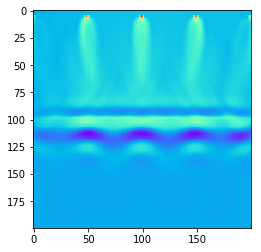

In [79]:
bg = slow.clone()
bg.getNdArray()[:] *= 0.95
born.setBgSlow(bg)
born.adjoint(False,image,data)
plt.imshow(image.getNdArray().real,cmap='rainbow')
plt.show()

In [12]:
par["onepass"] = 1
par["orz"] = (n2-1)*d2
slowNd = slow.getNdArray()
slowNd[:].real = 1/2000
parObj = genericIO.pythonParams(par).getCpp()

In [13]:
wem = WEM.WEM(slow,data,wave,parObj)
wem.forward(False,slow,data)

In [14]:
born.setBgSlow(slow)
born.adjoint(False,image,data)

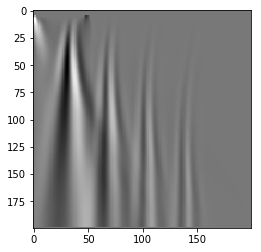

In [15]:
plt.imshow(image.getNdArray().real,cmap='gray')
plt.show()

# Conformal map

In [10]:
import json
cx = n1/2 * d1
cz = n2/2 * d2
r = .75 * min(n2 * d2/2,n1*d1/2)
th = np.linspace(0,np.pi,par['ns'])
x = cx - r * np.cos(th)
z = cz - r * np.sin(th)

dic = {}
# dic['rx'] = x.tolist()
# dic['rz'] = z.tolist()
# dic['sx'] = x.tolist()
# dic['sz'] = z.tolist()
dic['rx'] = x.tolist()
dic['rz'] = z.tolist()
dic['sx'] = x.tolist()
dic['sz'] = z.tolist()
with open('irreg.json','w') as f:
    json.dump(dic,f,indent=4)
    
par = {
    "coord" : 'irreg.json',
    "ns" : 100,
    "dsx" : d1,
    "osx" : 0,
    "dsz" : 0,
    
    "nr" : 100,
    "drx" : d1,
    "orx" : 0,
    "drz" : 0,
    "orz" : 0,
    
    "fmax" : 15,
    "fmin" : 1,   
    
    "nref" : 1,
    "tap" : 0,
    "ng" : 3,
    "prop" : 'ssf',
    
    "ntaylor" : 1,
    "onepass" : 1,
    "cmap" : 1   
}

parObj = genericIO.pythonParams(par).getCpp()

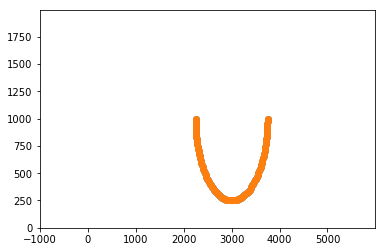

In [11]:
plt.scatter(dic['rx'],dic['rz'])
plt.scatter(dic['sx'],dic['sz'])
plt.xlim([o1,(n1-1)*d1])
plt.ylim([o2,(n2-1)*d2])
plt.show()

In [12]:
wem = WEM.WEM(slow,data,wave,parObj)
wem.forward(False,slow,data)

In [13]:
# for i in range(par["ns"]):
#     if i > 2:
#         datNd[i,i-3:i+3,:] = 0

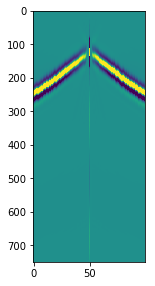

In [14]:

plt.figure(figsize=[2,100])
plt.imshow(datNd[50,:,:].T,vmin=-1e-2,vmax=1e-2,aspect=0.3)
plt.show()

In [15]:
slow.scale(1.1)
res = data.clone()
wem.forward(False,slow,res)
res = res.scaleAdd(data,1,-1)
image = slow.clone()
born = WEM.Born(slow,data,wave,parObj)
born.adjoint(False,image,res)

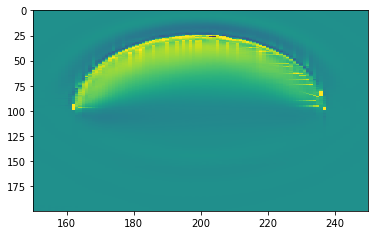

In [21]:
plt.imshow(image.getNdArray().real,vmin=-1,vmax=1,aspect=.3)
plt.xlim([150,250])
# plt.ylim([0,50])
plt.show()

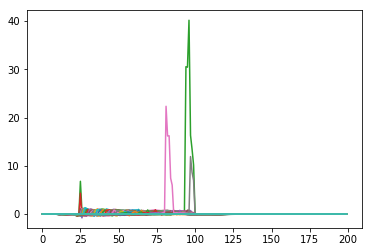

In [19]:
plt.plot(image.getNdArray().real)
# plt.xlim([150,250])
# plt.ylim([0,50])
plt.show()

In [ ]:
slowNd[int(n2/2):3*int(n2/4),int(n1/2):3*int(n1/4)] = 1/1000
plt.imshow(slowNd.real,aspect=.3)
# plt.ylim([0,50])
plt.show()

In [ ]:
bg = slow.clone()
bgNd = bg.getNdArray()
bgNd[:] = 1/2000

In [ ]:
wem.forward(False,slow,data)

In [ ]:
res = data.clone()
wem.forward(False,bg,res)
res = res.scaleAdd(data,1,-1)

In [ ]:
born = WEM.Born(bg,data,wave,parObj)
born.adjoint(False,image,res)

In [ ]:
plt.imshow(image.getNdArray().real,vmin=-3e-3,vmax=3e-3,aspect=.3)
plt.xlim([150,250])
# plt.ylim([0,50])
plt.show()

In [ ]:
np.amax(image.getNdArray().real)